# Import libraries

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML preprocessing/optimizing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import shap


# Scoring
from sklearn.metrics import roc_auc_score

# Data formatting/preprocessing
import time 
import tqdm
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# NaN Imputer
from sklearn.impute import KNNImputer



# Ml models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb


### Advanse optimizing (HyperOpt Parameter Tuning)
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

## Useful
pd.set_option('display.max_columns', None)

%matplotlib inline 

# Part 1. Data preprocessing

## Reading data

In [2]:
with open('train_part1.pkl', 'rb') as f1:
    train_part1 = pickle.load(f1)
    train_part1 = train_part1.iloc[:50000,:]

with open('train_part2.pkl', 'rb') as f2:
    train_part2 = pickle.load(f2)
    train_part2 = train_part2.iloc[:50000,:]
    
with open('test_data.pkl', 'rb') as f3:
    test_data = pickle.load(f3)
    test_data = test_data.iloc[:50000,:]

## Distribution of target

In [3]:
train_part1.TARGET.value_counts()

0    47902
1     2098
Name: TARGET, dtype: int64

In [4]:
train_part2.TARGET.value_counts()

0    47916
1     2084
Name: TARGET, dtype: int64

#### We can see class disbalance problem

# Shapes

In [5]:
train_part1.shape

(50000, 648)

In [6]:
train_part2.shape

(50000, 648)

In [7]:
train_part1 = train_part1.iloc[:100000,:]

In [8]:
train_part2 = train_part2.iloc[:100000,:]

#### the same

# Plan

- проделать препроцессинг для второй части трайн сета
- построить shap values
- обучить градиентынй бустинг
- пофитить гиперпараметры (random search + hyperopt)
- засабмитить первый скор

# Numeric data preprocess

In [9]:
def preprocess_data(data):
    '''
    Fill nans and label encode
    '''
    for i, col in enumerate(data.columns[1:]):
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            #joblib.dump(le, MODELS_PATH + f'le_{col}.pkl')
    return data

def numeric_preprocess(data):
    """This function operates with numerical data,
    it fills na with mean values and replaces inf by nan and reduces them"""
    
    data = data.select_dtypes(include=np.number).apply(lambda x: x.fillna(x.mean()),axis=0).replace([np.inf, -np.inf], np.nan).dropna()
    data = data.select_dtypes(include=np.number)
    data = data.set_index('ID')
    
    cat_columns = data.columns[data.nunique() < 10]
    num_columns = data.columns[data.nunique() >= 10]
    data = pd.concat([ data[cat_columns].fillna(data[cat_columns].mode().iloc[0,:]), data[num_columns].fillna(data[num_columns].mean()) ], axis=1)
    data = preprocess_data(data)
    return data





### Concatenate two train parts

In [10]:
numeric_data = pd.concat([numeric_preprocess(train_part1), numeric_preprocess(train_part2)], axis = 0)

In [11]:
# numeric_data = numeric_preprocess(train_part1)
# numeric_data = numeric_data.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)

# Non numeric preprocess

In [12]:
def non_numeric_preprocess(data):
    """This function handles with non numeric data (only 18 columns)
    It is worth mention that mapping part required additional analysis"""
    
    # set id as index
    data = data.set_index('ID')
    
    # Exclude numerics but not target
    target = data['TARGET']
    data = data.select_dtypes(exclude=np.number)
    data = pd.concat([data, target], axis = 1)
    
    # count the duration of cradit period
    data['period'] = (data['REPORT_DT'] - data['x_9']).dt.days
    
    # drop lot significant feeatures
    data = data.drop(['x_617', 'x_618','x_17', 'x_25', 'x_26', 'x_27', 'REPORT_DT', 'x_9'], axis = 1)
    
    return data

def rating_mean(data, name):
    """This function provides us with a dataframe that contains mean values of target.
    We will use the to encide categorical features"""
    
    a = []
    for i in data.select_dtypes(exclude=np.number)['{}'.format(name)].unique():
        a.append(data[data['{}'.format(name)] == i].TARGET.mean())

    res = pd.DataFrame([data.select_dtypes(exclude=np.number)['{}'.format(name)].unique(), a])    
    res=res.T.sort_values(by = 1)
    return res

def mapping_non_numerics(data_resource, data_final):
    """Here we use 2 data bases for proper categorical feature encoding (non overlaping)"""
    
    # handle with binaries
    #binaries = ['x_19', 'x_614', 'x_615', 'x_634']
    #data_final[binaries] = data_final[binaries].apply(pd.to_numeric)
    
    # x_12 client significance
    mapping = rating_mean(data_resource, 'x_12').set_index(0).to_dict()[1]
    data_final['x_12'].replace(mapping, inplace=True)
    
    # x_18

    
    not_weekend = data_resource[((data_resource['x_18'] != 'Вс') & (data_resource['x_18'] != 'Сб'))].TARGET.mean()
    weekend = data_resource[((data_resource['x_18'] == 'Вс') | (data_resource['x_18'] == 'Сб'))].TARGET.mean()
    map_18 = {'Вс':weekend, 
         'Сб':weekend,
         'Пн':not_weekend,
         'Чт':not_weekend,
         'Вт':not_weekend,
         'Пт':not_weekend,
         'Ср':not_weekend}
    
    data_final['x_18'].replace(map_18, inplace=True)
    
    # x_13
    map_x_13 = rating_mean(data_resource, 'x_13')
    not_1 = data_resource[data_resource['x_13'] != '1'].TARGET.mean()
    map_13 = {'1':map_x_13.iloc[2,1], 
             '2':not_1,
             '3':not_1,
             '4':not_1,
             '5':not_1,
             '9':not_1,
             '19':not_1}
    
    data_final['x_13'].replace(map_13, inplace=True)
    
    # x_21
    x_21 = rating_mean(data_resource, 'x_21')
    map_21 = x_21.set_index(0).to_dict()[1]
    data_final['x_21'].replace(map_21, inplace=True)
    
    # x_625 town or not
    x_625 = rating_mean(data_resource, 'x_625')
    map_625 = x_625.set_index(0).to_dict()[1]
    data_final['x_625'].replace(map_625, inplace=True)
    
    # x_628
    x_628 = rating_mean(data_resource, 'x_628')
    map_628 = x_628.set_index(0).to_dict()[1]
    data_final['x_628'].replace(map_628, inplace=True)
    

## Lets check, how mean target is connected with categorical features

In [13]:
for i in train_part1.select_dtypes(exclude=np.number).columns:
    try:
        print('non numeric feature {}'.format(i))
        print(rating_mean(train_part1, i))
        print("##############################################")
    except ValueError: 
        pass

non numeric feature REPORT_DT
             0         1
958 2019-04-06       0.0
774 2017-07-14       0.0
775 2018-09-08       0.0
776 2018-01-19       0.0
777 2019-11-15       0.0
..         ...       ...
778 2017-06-20  0.159091
534 2019-08-08      0.16
376 2019-04-10  0.163265
702 2019-02-05  0.166667
372 2019-10-22  0.261905

[959 rows x 2 columns]
##############################################
non numeric feature x_9
              0    1
1760 2015-06-21  0.0
627  2017-09-23  0.0
1438 2015-03-14  0.0
629  2016-10-21  0.0
1437 2017-12-14  0.0
...         ...  ...
1506 2016-04-10  1.0
1417 2012-11-05  1.0
1701 2012-10-03  1.0
1725 2016-02-07  1.0
1644 2012-06-14  1.0

[1761 rows x 2 columns]
##############################################
non numeric feature x_12
    0         1
6  A1  0.025641
5   B  0.036011
0  B1  0.036339
3   A   0.04067
1   D  0.048125
2   N  0.049365
4   C  0.056039
##############################################
non numeric feature x_13
     0         1
6   19   

## Change the categorical values by mapping avoiding overlapping

In [14]:
train_1_base = non_numeric_preprocess(train_part1.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1))
train_1_final = train_1_base.copy()
train_2_base = non_numeric_preprocess(train_part2)
train_2_final = train_2_base.copy()

mapping_non_numerics(train_2_base, train_1_final)
mapping_non_numerics(train_1_base, train_2_final)

In [15]:
cat_data = pd.concat([train_1_final, train_2_final], axis = 0)

In [16]:
cat_data.rename(columns={'x_12':'client_significance', 'x_18':'day_of_week', 'x_21':'credit_purpose',
                            'x_625':'city', 'x_628':'street'}, inplace = True)

# Combining (already non) catigorical and numerical training data

#### both dataframes contain TARGET, so one we will remove


In [17]:
train = numeric_data.drop(['TARGET'], axis = 1).merge(cat_data, left_index=True, right_index=True)

##### x_0 and x_1 are meaningless so drop them

In [18]:
train = train.drop(['x_0', 'x_1'], axis = 1)

## Correlation between target and numerical features

In [19]:
features = train.drop(['TARGET'], axis = 1)
target = train['TARGET']

In [20]:
cols = features.select_dtypes(include=np.number).columns
l = []
for i in range(len(cols)):
    l.append(target.corr(train.loc[:,cols[i]]))

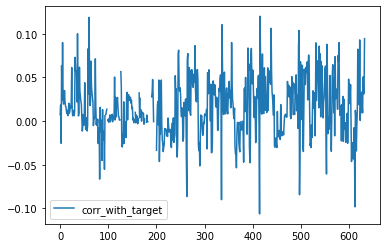

In [21]:
corr_data = pd.DataFrame([cols, l]).T.iloc[:,:]
corr_data = corr_data.rename(columns={0:'feature', 1:'corr_with_target'})
corr_data['corr_with_target'] = pd.to_numeric(corr_data['corr_with_target'])
corr_data.plot();

In [22]:
corr_data

,feature,corr_with_target
0,x_2,0.007390
1,x_3,0.018388
2,x_53,-0.025386
3,x_57,0.063184
4,x_79,0.024148
...,...,...
628,day_of_week,0.009497
629,credit_purpose,0.050629
630,city,0.030870
631,street,0.032638


### Plot top 15 the most correlated and the least

In [23]:
corr_data.nlargest(15, 'corr_with_target')

,feature,corr_with_target
415,x_292,0.120061
60,x_286,0.118771
336,x_189,0.110396
438,x_330,0.106254
496,x_421,0.103787
36,x_183,0.100030
632,period,0.094378
622,x_643,0.092951
356,x_227,0.089962
5,x_80,0.089861


In [24]:
corr_data.nsmallest(15, 'corr_with_target')

,feature,corr_with_target
414,x_291,-0.106254
612,x_630,-0.098137
335,x_188,-0.089962
263,x_85,-0.086378
497,x_422,-0.084289
82,x_346,-0.066374
553,x_543,-0.060568
92,x_370,-0.055182
366,x_237,-0.053416
290,x_134,-0.051340


#### The idea is that simple linear correlation can tell us what features have more significant linear dependence - these features from the first point of view are better and should be chosen

## Facts from categorical data

- Looks like weekends positively reflects on credibility 
 (maybe because people working during the week and can receive a credit only on the weekends)
- client status matters (A1 - N)
- living in city matters (city -> more income -> better credibility)
- more period -> more default rate!
- loan on street -> more default rate
- credit purpose matters!

#### provement for days of week 

In [25]:
a = []
for i in train_part1.select_dtypes(exclude=np.number).x_18.unique():
    a.append(train_part1[train_part1['x_18'] == i].TARGET.mean())

res = pd.DataFrame([train_part1.select_dtypes(exclude=np.number).x_18.unique(), a])    
res.T.sort_values(by = 1)

,0,1
6,Вс,0.029197
5,Сб,0.03393
2,Ср,0.040252
0,Пн,0.041727
4,Вт,0.042069
1,Чт,0.042311
3,Пт,0.047195


# Test data preparation

In [26]:
test_data

,REPORT_DT,x_0,x_1,x_2,x_3,x_4,x_5,x_7,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,x_80,x_81,x_82,x_83,x_84,x_85,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,x_109,x_110,x_111,x_112,x_113,x_114,x_115,x_116,x_117,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_158,x_159,x_160,x_161,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_182,x_183,x_184,x_185,x_186,x_187,x_188,x_189,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_204,x_205,x_206,x_207,x_208,x_209,x_210,x_211,x_212,x_213,x_214,x_215,x_216,x_217,x_218,x_219,x_220,x_221,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_263,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_280,x_281,x_282,x_283,x_284,x_285,x_286,x_287,x_288,x_289,x_290,x_291,x_292,x_293,x_294,x_295,x_296,x_297,x_298,x_299,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_308,x_309,x_310,x_311,x_312,x_313,x_314,x_315,x_316,x_317,x_318,x_319,x_320,x_321,x_322,x_323,x_324,x_325,x_326,x_327,x_328,x_329,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_340,x_341,x_342,x_343,x_344,x_345,x_346,x_347,x_348,x_349,x_350,x_351,x_352,x_353,x_354,x_355,x_356,x_357,x_358,x_359,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_367,x_368,x_369,x_370,x_371,x_372,x_373,x_374,x_375,x_376,x_377,x_378,x_379,x_380,x_381,x_382,x_383,x_384,x_385,x_386,x_387,x_388,x_389,x_390,x_391,x_392,x_393,x_394,x_395,x_396,x_397,x_398,x_399,x_400,x_401,x_402,x_403,x_404,x_405,x_406,x_407,x_408,x_409,x_410,x_411,x_412,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_420,x_421,x_422,x_423,x_424,x_425,x_426,x_427,x_428,x_429,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_439,x_440,x_441,x_442,x_443,x_444,x_445,x_446,x_447,x_448,x_449,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_467,x_468,x_469,x_470,x_471,x_472,x_473,x_474,x_475,x_476,x_477,x_478,x_479,x_480,x_481,x_482,x_483,x_484,x_485,x_486,x_487,x_488,x_489,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_500,x_501,x_502,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_510,x_511,x_512,x_513,x_514,x_515,x_516,x_517,x_518,x_519,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_527,x_528,x_529,x_530,x_531,x_532,x_533,x_534,x_535,x_536,x_537,x_538,x_539,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_550,x_551,x_552,x_553,x_554,x_555,x_556,x_557,x_558,x_559,x_560,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_568,x_569,x_570,x_571,x_572,x_573,x_574,x_575,x_576,x_577,x_578,x_579,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_608,x_609,x_610,x_611,x_612,x_613,x_614,x_615,x_616,x_617,x_618,x_619,x_620,x_621,x_622,x_623,x_624,x_625,x_626,x_627,x_628,x_629,x_630,x_631,x_632,x_633,x_634,x_635,x_636,x_637,x_638,x_639,x_640,x_641,x_642,x_643,x_644,x_645,x_646,ID
1943531,2019-09-01,1,0,1,1,1100000.0,157773.90,157773.90,2014-10-25,1000000.0,120,D,4,37,2.0,2.0,None,Сб,0,0.00,Приобретение,120,1000000.0,1270000.0,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [27]:
def non_numeric_preprocess_test(data):
    """This function handles with non numeric data (only 18 columns)
    It is worth mention that mapping part required additional analysis"""
    
    # set id as index
    data = data.set_index('ID')
    
    # Exclude numerics but not target
    #target = data['TARGET']
    data = data.select_dtypes(exclude=np.number)
    #data = pd.concat([data, target], axis = 1)
    
    # count the duration of cradit period
    data['period'] = (data['REPORT_DT'] - data['x_9']).dt.days
    
    # drop lot significant feeatures
    data = data.drop(['x_617', 'x_618','x_17', 'x_25', 'x_26', 'x_27', 'REPORT_DT', 'x_9'], axis = 1)
    
    return data

In [28]:
numeric_test_data = numeric_preprocess(test_data)
numeric_test_data = numeric_test_data.drop(['x_0', 'x_1'], axis = 1)


test_cat = non_numeric_preprocess_test(test_data)
test_cat.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)
mapping_non_numerics(train_2_base, test_cat)
test_cat = test_cat.drop(['x_19', 'x_614', 'x_615', 'x_634'], axis = 1)
test_cat.rename(columns={'x_12':'client_significance', 'x_18':'day_of_week', 'x_21':'credit_purpose',
                            'x_625':'city', 'x_628':'street'}, inplace = True)

test = numeric_test_data.merge(test_cat, left_index=True, right_index=True)

## Shapes of train and test detesets corresponds (test does not contain target)

In [29]:
test.shape

(49997, 633)

In [30]:
train.shape

(99995, 638)

In [37]:
train
cat_columns = train.columns[train.nunique() < 10]
num_columns = train.columns[train.nunique() >= 10]
train[cat_columns] = train[cat_columns].fillna(train[cat_columns].mode().iloc[0,:]) 
train = train

# Part 2. Machine Learning

In [38]:
X = train.drop(['TARGET'], axis = 1)
y = train['TARGET']


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [40]:
X_train

,x_2,x_3,x_53,x_57,x_79,x_80,x_81,x_82,x_83,x_87,x_88,x_89,x_90,x_91,x_95,x_101,x_102,x_103,x_105,x_106,x_107,x_108,x_109,x_110,x_111,x_112,x_113,x_114,x_116,x_117,x_118,x_158,x_159,x_160,x_161,x_182,x_183,x_184,x_185,x_186,x_190,x_191,x_192,x_193,x_194,x_204,x_205,x_206,x_208,x_209,x_210,x_214,x_215,x_216,x_217,x_219,x_220,x_221,x_263,x_285,x_286,x_287,x_288,x_289,x_293,x_294,x_295,x_296,x_297,x_308,x_309,x_312,x_313,x_317,x_318,x_319,x_320,x_323,x_324,x_343,x_344,x_345,x_346,x_347,x_355,x_356,x_357,x_358,x_359,x_367,x_368,x_369,x_370,x_371,x_376,x_377,x_378,x_379,x_380,x_384,x_388,x_392,x_396,x_400,x_404,x_406,x_407,x_408,x_409,x_410,x_411,x_412,x_423,x_426,x_427,x_428,x_429,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_441,x_442,x_445,x_446,x_447,x_448,x_467,x_476,x_479,x_480,x_482,x_483,x_486,x_487,x_489,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_501,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_510,x_511,x_512,x_513,x_514,x_519,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_530,x_531,x_532,x_533,x_534,x_553,x_554,x_555,x_556,x_557,x_558,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_573,x_583,x_585,x_586,x_608,x_612,x_623,x_624,x_626,x_633,x_636,x_4,x_5,x_7,x_10,x_11,x_14,x_15,x_16,x_20,x_22,x_23,x_24,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_54,x_55,x_56,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_84,x_85,x_86,x_92,x_93,x_94,x_96,x_97,x_98,x_99,x_100,x_104,x_115,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_187,x_188,x_189,x_195,x_196,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_207,x_211,x_212,x_213,x_218,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_280,x_281,x_282,x_283,x_284,x_290,x_291,x_292,x_298,x_299,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_310,x_311,x_314,x_315,x_316,x_321,x_322,x_325,x_326,x_327,x_328,x_329,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_340,x_341,x_342,x_348,x_349,x_350,x_351,x_352,x_353,x_354,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_372,x_373,x_374,x_375,x_381,x_382,x_383,x_385,x_386,x_387,x_389,x_390,x_391,x_393,x_394,x_395,x_397,x_398,x_399,x_401,x_402,x_403,x_405,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_420,x_421,x_422,x_424,x_425,x_439,x_440,x_443,x_444,x_449,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_468,x_469,x_470,x_471,x_472,x_473,x_474,x_475,x_477,x_478,x_481,x_484,x_485,x_488,x_500,x_502,x_515,x_516,x_517,x_518,x_527,x_528,x_529,x_535,x_536,x_537,x_538,x_539,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_550,x_551,x_552,x_559,x_560,x_568,x_569,x_570,x_571,x_572,x_574,x_575,x_576,x_577,x_578,x_579,x_580,x_581,x_582,x_584,x_587,x_588,x_589,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_609,x_610,x_611,x_613,x_616,x_619,x_620,x_621,x_622,x_627,x_629,x_630,x_631,x_632,x_635,x_637,x_638,x_639,x_640,x_641,x_642,x_643,x_644,x_645,x_646,client_significance,x_13,day_of_week,credit_purpose,city,street,period,x_19,x_614,x_615,x_634
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [41]:
X_test

,x_2,x_3,x_53,x_57,x_79,x_80,x_81,x_82,x_83,x_87,x_88,x_89,x_90,x_91,x_95,x_101,x_102,x_103,x_105,x_106,x_107,x_108,x_109,x_110,x_111,x_112,x_113,x_114,x_116,x_117,x_118,x_158,x_159,x_160,x_161,x_182,x_183,x_184,x_185,x_186,x_190,x_191,x_192,x_193,x_194,x_204,x_205,x_206,x_208,x_209,x_210,x_214,x_215,x_216,x_217,x_219,x_220,x_221,x_263,x_285,x_286,x_287,x_288,x_289,x_293,x_294,x_295,x_296,x_297,x_308,x_309,x_312,x_313,x_317,x_318,x_319,x_320,x_323,x_324,x_343,x_344,x_345,x_346,x_347,x_355,x_356,x_357,x_358,x_359,x_367,x_368,x_369,x_370,x_371,x_376,x_377,x_378,x_379,x_380,x_384,x_388,x_392,x_396,x_400,x_404,x_406,x_407,x_408,x_409,x_410,x_411,x_412,x_423,x_426,x_427,x_428,x_429,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_441,x_442,x_445,x_446,x_447,x_448,x_467,x_476,x_479,x_480,x_482,x_483,x_486,x_487,x_489,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_501,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_510,x_511,x_512,x_513,x_514,x_519,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_530,x_531,x_532,x_533,x_534,x_553,x_554,x_555,x_556,x_557,x_558,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_573,x_583,x_585,x_586,x_608,x_612,x_623,x_624,x_626,x_633,x_636,x_4,x_5,x_7,x_10,x_11,x_14,x_15,x_16,x_20,x_22,x_23,x_24,x_28,x_29,x_30,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49,x_50,x_51,x_52,x_54,x_55,x_56,x_58,x_59,x_60,x_61,x_62,x_63,x_64,x_65,x_66,x_67,x_68,x_69,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_84,x_85,x_86,x_92,x_93,x_94,x_96,x_97,x_98,x_99,x_100,x_104,x_115,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_187,x_188,x_189,x_195,x_196,x_197,x_198,x_199,x_200,x_201,x_202,x_203,x_207,x_211,x_212,x_213,x_218,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_280,x_281,x_282,x_283,x_284,x_290,x_291,x_292,x_298,x_299,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_310,x_311,x_314,x_315,x_316,x_321,x_322,x_325,x_326,x_327,x_328,x_329,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_340,x_341,x_342,x_348,x_349,x_350,x_351,x_352,x_353,x_354,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_372,x_373,x_374,x_375,x_381,x_382,x_383,x_385,x_386,x_387,x_389,x_390,x_391,x_393,x_394,x_395,x_397,x_398,x_399,x_401,x_402,x_403,x_405,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_420,x_421,x_422,x_424,x_425,x_439,x_440,x_443,x_444,x_449,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_468,x_469,x_470,x_471,x_472,x_473,x_474,x_475,x_477,x_478,x_481,x_484,x_485,x_488,x_500,x_502,x_515,x_516,x_517,x_518,x_527,x_528,x_529,x_535,x_536,x_537,x_538,x_539,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_550,x_551,x_552,x_559,x_560,x_568,x_569,x_570,x_571,x_572,x_574,x_575,x_576,x_577,x_578,x_579,x_580,x_581,x_582,x_584,x_587,x_588,x_589,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_609,x_610,x_611,x_613,x_616,x_619,x_620,x_621,x_622,x_627,x_629,x_630,x_631,x_632,x_635,x_637,x_638,x_639,x_640,x_641,x_642,x_643,x_644,x_645,x_646,client_significance,x_13,day_of_week,credit_purpose,city,street,period,x_19,x_614,x_615,x_634
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [44]:
xgb_model = xgb.XGBRegressor(enable_categorical= True)
xgb_model.fit(X_train, y_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.x_19, x_614, x_615, x_634

In [293]:
xgb_model.feature_importances_

array([2.5055892e-04, 8.9918416e-05, 5.6019315e-04, 4.1249397e-04,
       1.8447242e-03, 1.3157002e-03, 1.3721955e-03, 1.5787096e-03,
       1.3881394e-03, 1.5336297e-03, 1.0957278e-03, 0.0000000e+00,
       0.0000000e+00, 2.4249840e-03, 1.5004907e-03, 8.7730709e-04,
       8.4316061e-04, 1.4411095e-03, 1.1011709e-03, 1.7112944e-03,
       1.1044800e-03, 4.6179479e-04, 1.3840534e-03, 1.5546597e-03,
       1.2327151e-03, 7.3269039e-04, 7.8124495e-04, 1.0147123e-03,
       1.0747808e-03, 2.0395205e-03, 3.1316257e-04, 2.8104284e-03,
       1.9981533e-03, 2.8084000e-03, 1.0175079e-05, 2.8683036e-03,
       1.9135872e-03, 1.8083727e-03, 1.2664421e-03, 2.1497037e-03,
       1.9537599e-04, 4.1968681e-04, 1.5464622e-03, 4.6391637e-04,
       8.2534342e-04, 8.5355953e-04, 7.3141843e-04, 7.7126099e-04,
       3.4952397e-03, 2.3267027e-03, 1.2881610e-03, 1.3178427e-03,
       4.7972049e-03, 1.7815348e-03, 3.0316005e-04, 5.3735409e-04,
       1.2808064e-03, 1.3144726e-03, 8.8316697e-04, 6.9108873e

In [297]:
importance = pd.DataFrame(xgb_model.feature_importances_, X_train.columns).reset_index().rename(columns={0:'importance', 1:'factor'})



In [298]:
importance.sort_values(by='importance')

,index,importance
316,x_330,0.000000
370,x_384,0.000000
369,x_383,0.000000
367,x_381,0.000000
366,x_380,0.000000
...,...,...
156,x_170,0.008068
256,x_270,0.008189
438,x_452,0.016366
272,x_286,0.036443


In [304]:
importance.nlargest(25, 'importance')

,index,importance
332,x_346,0.181300
272,x_286,0.036443
438,x_452,0.016366
256,x_270,0.008189
156,x_170,0.008068
278,x_292,0.007358
288,x_302,0.007054
610,x_630,0.006449
436,x_450,0.005349
414,x_428,0.005324


In [303]:
importance

,index,importance
0,x_2,0.000251
1,x_3,0.000090
2,x_4,0.000560
3,x_5,0.000412
4,x_7,0.001845
...,...,...
628,day_of_week,0.001004
629,credit_purpose,0.001286
630,city,0.001217
631,street,0.001171


In [305]:
y_pred = xgb_model.predict(X_test)

In [306]:
roc_auc_score(y_test, y_pred)

0.822327863552536

## Let's use only 25 most important features

In [313]:
features_25 = np.array(importance.nlargest(25, 'importance')['index'])

In [314]:
xgb_model_reduced = xgb.XGBRegressor()
xgb_model_reduced.fit(X_train[features_25], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [316]:
y_pred_reduced = xgb_model_reduced.predict(X_test[features_25])

In [317]:
roc_auc_score(y_test, y_pred_reduced)

0.7932086532279361

## Let's use only 20 most important features and significant categorical variables

In [346]:
features_new = list(np.array(importance.nlargest(19, 'importance')['index']))
important_cat_values = list(['client_significance', 'day_of_week', 'credit_purpose',
                                 'city', 'street', 'period'])

features_new.extend(important_cat_values)


In [349]:
xgb_model_reduced_with_cat = xgb.XGBRegressor()
xgb_model_reduced_with_cat.fit(X_train[features_new], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [350]:
y_pred_reduced_1 = xgb_model_reduced_with_cat.predict(X_test[features_new])

In [351]:
roc_auc_score(y_test, y_pred_reduced_1)

0.7948199717355685

### catboost + hyperopt

In [359]:
import sklearn
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [360]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    params['border_count'] = space['border_count']
    #params['rsm'] = space['rsm']
    return params

In [361]:
obj_call_count = 0
cur_best_loss = np.inf
log_writer = open( 'catboost-hyperopt-log.txt', 'w' )

In [383]:
D_train = catboost.Pool(X_train[features_new].iloc[:1000,:], y_train[:1000])
D_test = catboost.Pool(X_test[features_new].iloc[:1000,:], y_test[:1000])

In [386]:

def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=1000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

In [387]:
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best )
print('\n\n')

                                                      
CatBoost objective call #6 cur_best_loss=    inf
Params: border_count=55.65632609422184 depth=4.0 l2_leaf_reg=7.99823809308144 learning_rate=0.02855826013286454
nb_trees=42                                           
NEW BEST LOSS=0.18683780140468706                     
                                                                                 
CatBoost objective call #7 cur_best_loss=0.18684
Params: border_count=74.14586013188347 depth=5.0 l2_leaf_reg=4.144010752382719 learning_rate=0.014844559387032432
nb_trees=30                                                                      
                                                                                 
CatBoost objective call #8 cur_best_loss=0.18684
Params: border_count=201.5866118855728 depth=3.0 l2_leaf_reg=3.2878835602715535 learning_rate=0.013415353835737304
nb_trees=94                                                                      
NEW BEST LOSS=0.185

                                                                                  
CatBoost objective call #54 cur_best_loss=0.16022
Params: border_count=87.4549317536063 depth=1.0 l2_leaf_reg=7.355496121557307 learning_rate=0.07929822030726086
nb_trees=39                                                                       
                                                                                  
CatBoost objective call #55 cur_best_loss=0.16022
Params: border_count=32.99655203339752 depth=6.0 l2_leaf_reg=5.900292634625017 learning_rate=0.06608976171458626
nb_trees=180                                                                      
                                                                                  
CatBoost objective call #56 cur_best_loss=0.16022
Params: border_count=71.28036875704315 depth=2.0 l2_leaf_reg=7.69715123140464 learning_rate=0.13256182915718567
nb_trees=35                                                                       
               

In [388]:
best.update({'border_count': int(best['border_count'])})

In [391]:
model = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best
                    )

model.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6516156	best: 0.6516156 (0)	total: 3ms	remaining: 3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8060568772
bestIteration = 42

Shrink model to first 43 iterations.


In [392]:
pred = model.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8060568772217664
acc =  0.952
loss =  0.16022148209761103


#### Received better results AUC is 0.8060568772217664, while before was 0.7948199717355685

### difference

In [393]:
0.8060568772217664 - 0.7948199717355685

0.011236905486197935

## more our data

In [434]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new], y_train)
D_test = catboost.Pool(X_test[features_new], y_test)


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=100,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=10,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [435]:
%time
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
                                                      
CatBoost objective call #254 cur_best_loss=0.15293
Params: border_count=76.10890885883015 depth=4.0 l2_leaf_reg=7.238740801916636 learning_rate=0.017816332991421005
nb_trees=100                                          
                                                                               
CatBoost objective call #255 cur_best_loss=0.15293
Params: border_count=138.33121711368142 depth=5.0 l2_leaf_reg=7.673035732408229 learning_rate=0.01128873038504781
nb_trees=52                                                                    
                                                                               
CatBoost objective call #256 cur_best_loss=0.15293
Params: border_count=49.73363640044286 depth=5.0 l2_leaf_reg=7.395086153941822 learning_rate=0.009051463521493538
nb_trees=47                                                                    
           

Params: border_count=214.28258496392172 depth=4.0 l2_leaf_reg=3.951331803973593 learning_rate=0.019610716302638446
nb_trees=98                                                                      
                                                                                 
CatBoost objective call #303 cur_best_loss=0.14999
Params: border_count=203.6363724181065 depth=2.0 l2_leaf_reg=5.117618830284612 learning_rate=0.0525869304602981
nb_trees=100                                                                     
                                                                                 
CatBoost objective call #304 cur_best_loss=0.14999
Params: border_count=238.0001248923852 depth=3.0 l2_leaf_reg=3.6142647795965592 learning_rate=0.04653351310729436
nb_trees=100                                                                     
                                                                                 
CatBoost objective call #305 cur_best_loss=0.14999
Params: border

In [436]:
best_1.update({'border_count': int(best_1['border_count'])})

In [437]:
model_1 = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6470018	best: 0.6470018 (0)	total: 87.2ms	remaining: 1m 27s
999:	test: 0.8048878	best: 0.8048878 (999)	total: 1m 29s	remaining: 0us

bestTest = 0.8048877684
bestIteration = 999



In [438]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8048877684482741
acc =  0.960187175787602
loss =  0.13999716979377957


# Optimize a little different metric

In [448]:
%time


obj_call_count = 0
cur_best_minus_auc = np.inf

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new], y_train)
D_test = catboost.Pool(X_test[features_new], y_test)


def objective(space):
    global obj_call_count, cur_best_minus_auc

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=100,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=10,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])
    minus_auc = -auc

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if minus_auc<cur_best_minus_auc:
        cur_best_minus_auc = minus_auc
        print(colorama.Fore.GREEN + 'NEW BEST minus_auc={}'.format(cur_best_minus_auc) + colorama.Fore.RESET)


    return{'loss':minus_auc, 'status': STATUS_OK }


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [449]:
%time
space = {
        'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.loguniform('learning_rate', -5.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
       }

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
                                                      
CatBoost objective call #1 cur_best_loss=    inf
Params: border_count=109.6993314873069 depth=5.0 l2_leaf_reg=5.0514002526193575 learning_rate=0.024868377820762948
nb_trees=100                                          
NEW BEST minus_auc=-0.7631474061602792                
                                                                                 
CatBoost objective call #2 cur_best_loss=    inf
Params: border_count=230.05618272280682 depth=4.0 l2_leaf_reg=7.347526571660698 learning_rate=0.03654557769921731
nb_trees=100                                                                     
NEW BEST minus_auc=-0.7639561052909645                                           
                                                                                 
CatBoost objective call #3 cur_best_loss=    inf
Params: border_count=173.1553662338939 depth=4.0 l2_leaf_reg=3.3637

Params: border_count=69.27221637804827 depth=4.0 l2_leaf_reg=7.739050351122218 learning_rate=0.06004854079103749
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #49 cur_best_loss=    inf
Params: border_count=45.381537362586016 depth=6.0 l2_leaf_reg=5.590631154087692 learning_rate=0.02364756111044745
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #50 cur_best_loss=    inf
Params: border_count=135.08447729042402 depth=5.0 l2_leaf_reg=7.160072558507705 learning_rate=0.11908554357146188
nb_trees=100                                                                      
                                                                                  
CatBoost objective call #51 cur_best_loss=    inf
Params: bor

In [450]:
best_1.update({'border_count': int(best_1['border_count'])})

In [451]:
model_1 = catboost.CatBoostClassifier(iterations=1000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6502255	best: 0.6502255 (0)	total: 80ms	remaining: 1m 19s
999:	test: 0.8058296	best: 0.8058296 (999)	total: 1m 32s	remaining: 0us

bestTest = 0.8058295812
bestIteration = 999



In [452]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.8058295812199296
acc =  0.9603102488432442
loss =  0.13956042905421484


## Another trial

In [423]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new].iloc[:10000,:], y_train[:10000])
D_test = catboost.Pool(X_test[features_new].iloc[:10000,:], y_test[:10000])


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=2000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [424]:
%time
space = {'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        'random_strength': hp.uniform('random_strength', 0.0, 100)}

trials = Trials()
best_1 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.34 µs
                                                      
CatBoost objective call #134 cur_best_loss=0.15293
Params: border_count=44.18442618014259 depth=2.0 l2_leaf_reg=5.8501581939044645 learning_rate=0.09565032097424465 random_strength=65.08591493875477
nb_trees=263                                          
                                                                                
CatBoost objective call #135 cur_best_loss=0.15293
Params: border_count=181.00620423293208 depth=5.0 l2_leaf_reg=5.050884950163192 learning_rate=0.5163662422796392 random_strength=96.89445930406278
nb_trees=11                                                                     
                                                                                
CatBoost objective call #136 cur_best_loss=0.15293
Params: border_count=100.99149003513901 depth=6.0 l2_leaf_reg=7.3293545610790645 learning_rate=0.3654930575569984 random_strength=8

nb_trees=14                                                                       
                                                                                  
CatBoost objective call #179 cur_best_loss=0.15293
Params: border_count=192.647522737345 depth=2.0 l2_leaf_reg=6.38499911382412 learning_rate=0.05058744390152494 random_strength=90.57868924636776
nb_trees=417                                                                      
                                                                                  
CatBoost objective call #180 cur_best_loss=0.15293
Params: border_count=85.6655200804106 depth=5.0 l2_leaf_reg=6.677850892839218 learning_rate=0.011015500651758806 random_strength=79.11044470093773
nb_trees=764                                                                      
                                                                                  
CatBoost objective call #181 cur_best_loss=0.15293
Params: border_count=53.70038321192758 depth=5.0 l2_leaf_

In [425]:
best_1.update({'border_count': int(best_1['border_count'])})

In [426]:
model_1 = catboost.CatBoostClassifier(iterations=2000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_1
                    )

model_1.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6527584	best: 0.6527584 (0)	total: 12.3ms	remaining: 24.6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7591598653
bestIteration = 466

Shrink model to first 467 iterations.


In [427]:
pred = model_1.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.7591598653449091
acc =  0.9565
loss =  0.15911881855277707


## new

In [429]:
%time

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

D_train = catboost.Pool(X_train[features_new].iloc[:10000,:], y_train[:10000])
D_test = catboost.Pool(X_test[features_new].iloc[:10000,:], y_test[:10000])


def objective(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostClassifier(iterations=10000,
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        loss_function='Logloss',
                                        use_best_model=True,
                                        eval_metric='AUC',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=300,
                                        od_type="Iter",
                                        border_count=int(params['border_count']),
                                        verbose=False
                                        )
    
    model.fit(D_train, eval_set=D_test, verbose=False)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    y_pred = model.predict_proba(D_test.get_features())
    test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    log_writer.flush()

    if test_loss<cur_best_loss:
        cur_best_loss = test_loss
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)


    return{'loss':test_loss, 'status': STATUS_OK }

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs


In [430]:
%time
space = {'depth': hp.quniform("depth", 1, 6, 1),
        'border_count': hp.uniform ('border_count', 32, 255),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
        'random_strength': hp.uniform('random_strength', 0.0, 100)}

trials = Trials()
best_2 = hyperopt.fmin(fn=objective,
                     space=space,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=True)

print('-'*50)
print('The best params:')
print( best_1 )
print('\n\n')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
                                                      
CatBoost objective call #194 cur_best_loss=0.15293
Params: border_count=65.20347642021926 depth=3.0 l2_leaf_reg=4.326186868317737 learning_rate=0.8513894749565964 random_strength=12.551373577866187
nb_trees=10                                           
                                                                                
CatBoost objective call #195 cur_best_loss=0.15293
Params: border_count=251.9806917873872 depth=2.0 l2_leaf_reg=7.079631565898139 learning_rate=0.037484926968818805 random_strength=25.053286842416878
nb_trees=629                                                                    
                                                                                
CatBoost objective call #196 cur_best_loss=0.15293
Params: border_count=196.07161919003335 depth=4.0 l2_leaf_reg=4.709714504450045 learning_rate=0.542361630045862 random_strength=86.226

nb_trees=459                                                                      
                                                                                  
CatBoost objective call #239 cur_best_loss=0.15293
Params: border_count=146.5046513300961 depth=3.0 l2_leaf_reg=4.837476892656008 learning_rate=0.059477505889160114 random_strength=99.84478005447161
nb_trees=218                                                                      
                                                                                  
CatBoost objective call #240 cur_best_loss=0.15293
Params: border_count=159.61660740581436 depth=5.0 l2_leaf_reg=5.341493292962689 learning_rate=0.796323594203127 random_strength=25.398692808891926
nb_trees=7                                                                        
                                                                                  
CatBoost objective call #241 cur_best_loss=0.15293
Params: border_count=198.35839448981085 depth=4.0 l2_l

In [431]:
best_2.update({'border_count': int(best_2['border_count'])})

In [432]:
model_2 = catboost.CatBoostClassifier(iterations=10000,
                    loss_function='Logloss',
                    use_best_model=True,
                    eval_metric='AUC',
                    early_stopping_rounds=300,
                    od_type="Iter",
                    verbose=2000,
                    **best_2
                    )

model_2.fit(D_train, eval_set=D_test, verbose=2000)

0:	test: 0.6663952	best: 0.6663952 (0)	total: 14.3ms	remaining: 2m 22s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7621648195
bestIteration = 940

Shrink model to first 941 iterations.


In [433]:
pred = model_2.predict_proba(D_test.get_features())
print("auc = ", sklearn.metrics.roc_auc_score(D_test.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(D_test.get_label(), pred, labels=[0, 1]))

auc =  0.762164819526915
acc =  0.9566
loss =  0.159220586293924


## LightGBM + random search

In [ ]:
model_lgb = lgb.LGBMRegressor(random_state=0)

distributions = {'learning_rate':[0.000001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
                 'max_depth' :[1,2,3,4,5,-1],
                 'n_estimators':[100,200, 300, 400, 600],
                 'boosting_type':['gbdt', 'dart', 'goss', 'rf'],
                 'random_state':[0],
                 'min_child_samples':[3,7, 10,20,40, 60],
                 'importance_type':['split', 'gain'],
                 'num_leaves': randint(6, 50), 
                 'min_child_samples': randint(100, 500), 
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'subsample': uniform(loc=0.2, scale=0.8), 
                 'colsample_bytree': uniform(loc=0.4, scale=0.6),
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model = RandomizedSearchCV(momodel_lgbdel, distributions, random_state=0, n_iter = 300, cv = 4, verbose=2, n_jobs = -1)
model = model.fit(X_train, y_train)
y_pred = model.best_estimator_.predict(X_train)

# XGBoodst + random search cv

In [ ]:
model = xgb.XGBRegressor(random_state=0)

distributions = {'learning_rate':[0.000001, 0.0001, 0.001, 0.01,0.05, 0.1, 0.5, 1],
                 'max_depth' :[1,2,3,4,5,-1],
                 'n_estimators':[100,200, 300, 400, 600],
                 'random_state':[0],
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'subsample': uniform(loc=0.2, scale=0.8), 
                 'colsample_bytree': uniform(loc=0.4, scale=0.6),
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model = RandomizedSearchCV(model, distributions, random_state=0, n_iter = 100, cv = 8, verbose=2, n_jobs = -1)
model = model.fit(X_train, y_train)
y_pred = model.best_estimator_.predict(X_train)

print(model.best_params_)
best_params.append(model.best_params_)

# SHAP values

In [ ]:
import xgboost as xgb

In [ ]:
comapre_data.drop(['x_646'], axis = 1)
comapre_data.replace([np.inf, -np.inf], np.nan)
comapre_data.dropna(inplace=True)
comapre_data = comapre_data.astype('float16')

X = comapre_data.drop(columns=['ID', 'TARGET'])
y = comapre_data['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

In [ ]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(xgb_model, X_train)
k_shap_values = k_explainer.shap_values(X_test)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

In [ ]:
train_part1.info()

In [ ]:
comapre_data.info()

# Only non numeric and 1000

In [ ]:
X = comapre_data[new_important].iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

# All and 1000

In [ ]:
X = comapre_data.iloc[:1000,:]
y = comapre_data['TARGET'][:1000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_train, y_pred_train)

In [ ]:
y_test.value_counts()

### Train_pert_1 and train_part_2 are similar

In [25]:
train_part2.describe() - train_part1.describe()

,ID,TARGET,x_0,x_1,x_10,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,x_108,x_109,x_11,x_110,x_111,x_112,x_113,x_114,x_115,x_116,x_117,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127,x_128,x_129,x_130,x_131,x_132,x_133,x_134,x_135,x_136,x_137,x_138,x_139,x_14,x_140,x_141,x_142,x_143,x_144,x_145,x_146,x_147,x_148,x_149,x_15,x_150,x_151,x_152,x_153,x_154,x_155,x_156,x_157,x_158,x_159,x_16,x_160,x_161,x_162,x_163,x_164,x_165,x_166,x_167,x_168,x_169,x_170,x_171,x_172,x_173,x_174,x_175,x_176,x_177,x_178,x_179,x_180,x_181,x_182,x_183,x_184,x_185,x_186,x_187,x_188,x_189,x_19,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199,x_2,x_20,x_200,x_201,x_202,x_203,x_204,x_205,x_206,x_207,x_208,x_209,x_210,x_211,x_212,x_213,x_214,x_215,x_216,x_217,x_218,x_219,x_22,x_220,x_221,x_222,x_223,x_224,x_225,x_226,x_227,x_228,x_229,x_23,x_230,x_231,x_232,x_233,x_234,x_235,x_236,x_237,x_238,x_239,x_24,x_240,x_241,x_242,x_243,x_244,x_245,x_246,x_247,x_248,x_249,x_250,x_251,x_252,x_253,x_254,x_255,x_256,x_257,x_258,x_259,x_260,x_261,x_262,x_263,x_264,x_265,x_266,x_267,x_268,x_269,x_270,x_271,x_272,x_273,x_274,x_275,x_276,x_277,x_278,x_279,x_28,x_280,x_281,x_282,x_283,x_284,x_285,x_286,x_287,x_288,x_289,x_29,x_290,x_291,x_292,x_293,x_294,x_295,x_296,x_297,x_298,x_299,x_3,x_30,x_300,x_301,x_302,x_303,x_304,x_305,x_306,x_307,x_308,x_309,x_31,x_310,x_311,x_312,x_313,x_314,x_315,x_316,x_317,x_318,x_319,x_32,x_320,x_321,x_322,x_323,x_324,x_325,x_326,x_327,x_328,x_329,x_33,x_330,x_331,x_332,x_333,x_334,x_335,x_336,x_337,x_338,x_339,x_34,x_340,x_341,x_342,x_343,x_344,x_345,x_346,x_347,x_348,x_349,x_35,x_350,x_351,x_352,x_353,x_354,x_355,x_356,x_357,x_358,x_359,x_36,x_360,x_361,x_362,x_363,x_364,x_365,x_366,x_367,x_368,x_369,x_37,x_370,x_371,x_372,x_373,x_374,x_375,x_376,x_377,x_378,x_379,x_38,x_380,x_381,x_382,x_383,x_384,x_385,x_386,x_387,x_388,x_389,x_39,x_390,x_391,x_392,x_393,x_394,x_395,x_396,x_397,x_398,x_399,x_4,x_40,x_400,x_401,x_402,x_403,x_404,x_405,x_406,x_407,x_408,x_409,x_41,x_410,x_411,x_412,x_413,x_414,x_415,x_416,x_417,x_418,x_419,x_42,x_420,x_421,x_422,x_423,x_424,x_425,x_426,x_427,x_428,x_429,x_43,x_430,x_431,x_432,x_433,x_434,x_435,x_436,x_437,x_438,x_439,x_44,x_440,x_441,x_442,x_443,x_444,x_445,x_446,x_447,x_448,x_449,x_45,x_450,x_451,x_452,x_453,x_454,x_455,x_456,x_457,x_458,x_459,x_46,x_460,x_461,x_462,x_463,x_464,x_465,x_466,x_467,x_468,x_469,x_47,x_470,x_471,x_472,x_473,x_474,x_475,x_476,x_477,x_478,x_479,x_48,x_480,x_481,x_482,x_483,x_484,x_485,x_486,x_487,x_488,x_489,x_49,x_490,x_491,x_492,x_493,x_494,x_495,x_496,x_497,x_498,x_499,x_5,x_50,x_500,x_501,x_502,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_51,x_510,x_511,x_512,x_513,x_514,x_515,x_516,x_517,x_518,x_519,x_52,x_520,x_521,x_522,x_523,x_524,x_525,x_526,x_527,x_528,x_529,x_53,x_530,x_531,x_532,x_533,x_534,x_535,x_536,x_537,x_538,x_539,x_54,x_540,x_541,x_542,x_543,x_544,x_545,x_546,x_547,x_548,x_549,x_55,x_550,x_551,x_552,x_553,x_554,x_555,x_556,x_557,x_558,x_559,x_56,x_560,x_561,x_562,x_563,x_564,x_565,x_566,x_567,x_568,x_569,x_57,x_570,x_571,x_572,x_573,x_574,x_575,x_576,x_577,x_578,x_579,x_58,x_580,x_581,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,x_59,x_590,x_591,x_592,x_593,x_594,x_595,x_596,x_597,x_598,x_599,x_60,x_600,x_601,x_602,x_603,x_604,x_605,x_606,x_607,x_608,x_609,x_61,x_610,x_611,x_612,x_613,x_614,x_615,x_616,x_619,x_62,x_620,x_621,x_622,x_623,x_624,x_626,x_627,x_629,x_63,x_630,x_631,x_632,x_633,x_634,x_635,x_636,x_637,x_638,x_639,x_64,x_640,x_641,x_642,x_643,x_644,x_645,x_646,x_65,x_66,x_67,x_68,x_69,x_7,x_70,x_71,x_72,x_73,x_74,x_75,x_76,x_77,x_78,x_79,x_80,x_81,x_82,x_83,x_84,x_85,x_86,x_87,x_88,x_89,x_90,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99
count,-4.000000,-4.000000,-4.0,-4.0,-4.000000,10.000000,-109.000000,-31.000000,-26.000000,10.000000,-109.000000,-31.000000,-26.000000,-248.000000,-248.000000,-4.00000,-248.000000,10.000000,-109.000000,-31.000000,-26.000000,10.000000,-109.000000,-31.000000,-26.000000,-248.000000,-248.000000,-2

In [26]:
train_part1.columns

Index(['REPORT_DT', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7', 'x_9',
       'x_10',
       ...
       'x_639', 'x_640', 'x_641', 'x_642', 'x_643', 'x_644', 'x_645', 'x_646',
       'TARGET', 'ID'],
      dtype='object', length=648)

In [28]:
train_part2.columns

Index(['REPORT_DT', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_7', 'x_9',
       'x_10',
       ...
       'x_639', 'x_640', 'x_641', 'x_642', 'x_643', 'x_644', 'x_645', 'x_646',
       'TARGET', 'ID'],
      dtype='object', length=648)

In [ ]:
train_part1.value_countse_counts()

In [ ]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.loguniform('tol', 0.00001, 10),
    'C' : hp.loguniform('C', 1, 5000),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}

space_dict = {
    'class_weight': [None, 'balanced'],
    'warm_start' : [True, False],
    'fit_intercept' : [True, False],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}